In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat


# carregar arquivo .mat
mat = loadmat('in_out_SBRT2_direto.mat')

in_data_ext = mat['in_extraction']
out_data_ext = mat['out_extraction']
in_data_val = mat['in_validation']
out_data_val = mat['out_validation']


lista = [in_data_ext, out_data_ext, in_data_val, out_data_val]

modulos = []
for i in lista:
    modulos.append(max(i.imag))
    modulos.append(max(i.real))

maior_modulo = max(modulos)

in_ext_norm  = in_data_ext / maior_modulo
out_ext_norm = out_data_ext /maior_modulo
in_val_norm  = in_data_val/maior_modulo
out_val_norm = out_data_val/maior_modulo

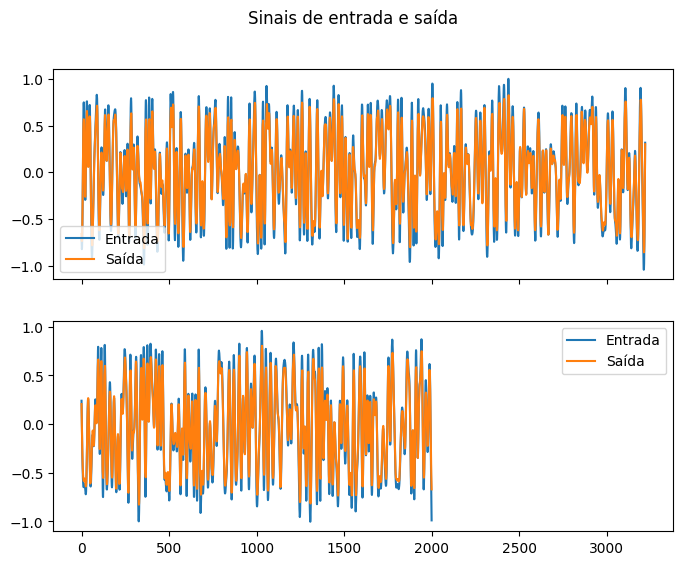

In [2]:
# plotar sinais de entrada e saída
x_ext = range(len(in_data_ext))
x_val = range(len(in_data_val))

fig, axs = plt.subplots(2, sharex=True, figsize=(8, 6))
fig.suptitle('Sinais de entrada e saída')
axs[0].plot(x_ext, np.real(in_ext_norm), label='Entrada')
axs[0].plot(x_ext, np.real(out_ext_norm), label='Saída')
axs[0].legend()
axs[1].plot(x_val, np.real(in_val_norm), label='Entrada')
axs[1].plot(x_val, np.real(out_val_norm), label='Saída')
axs[1].legend()
plt.show()

In [3]:
def mp(P, M, xn):
    L = xn.shape
    XX = np.zeros((L[0] - M, P * (M+1)), dtype=np.complex128)
    for l in range(M+1, L[0]):
        for p in range(1, P+1):
            for m in range(0, M+1):
                XX[l-M-1, ((p-1)*(M+1))+m] = (np.abs(xn[l-m])**(2*p-2)*(xn[l-m]))[0]
    return XX


def readeq(val, precision):
    return np.floor(val / (2 ** precision))

def mp_int(P, M, xn, bits):
    L = xn.shape
    XX = np.zeros((L[0] - M, P * (M+1)), dtype=np.complex128)
    for l in range(M+1, L[0]):
        for p in range(1, P+1):
            for m in range(0, M+1):
                    pot = int(2*p-2) 
                    A = np.real(xn[l-m])[0]
                    B = np.imag(xn[l-m])[0]
                    modulo_power = 2**bits 
                    modulo_square = readeq(A ** 2 + B ** 2, bits)
                    for _ in range(1, pot):
                       modulo_power = readeq(modulo_power * modulo_square, bits)
                    real_part = readeq(A * modulo_power,bits)
                    imag_part = readeq(B * modulo_power,bits)
                    XX[l-M-1, ((p-1)*(M+1))+m] = complex(real_part,imag_part)        
    return XX

def MultiplicadorMatrizes(coefficients, XX, precision):
    max_value = 0  
    result = np.zeros_like(XX, dtype=np.complex128)
    for i in range(XX.shape[0]):
        for j in range(XX.shape[1]):
            
            A = np.real(coefficients[j,0])
            B = np.imag(coefficients[j,0])
            C = np.real(XX[i, j])
            D = np.imag(XX[i, j])

            readequated_real = readeq(A*C, precision)  +  readeq(-B * D, precision)
            readequated_imag = readeq(A*D , precision) +  readeq(B*C, precision)

            max_value = max(max_value, readequated_real)
            max_value = max(max_value, readequated_imag)
            
            result[i, j] = complex(readequated_real, readequated_imag) 

    soma_filas = np.sum(result, axis=1).reshape(-1, 1)

    extra_bits = np.ceil(np.log2(max_value + 1))
    
    return soma_filas, extra_bits



In [65]:
def mp(P, M, xn):
    L = xn.shape
    XX = np.zeros((L[0] - M, P * (M+1)), dtype=np.complex128)
    for l in range(M+1, L[0]):
        for p in range(1, P+1):
            for m in range(0, M+1):
                XX[l-M-1, ((p-1)*(M+1))+m] = (np.abs(xn[l-m])**(2*p-2)*(xn[l-m]))[0]
    return XX


def readeq(val, precision):
    return np.floor(val / (2 ** precision))

def mp_int(P, M, xn, bits):
    L = xn.shape
    XX = np.zeros((L[0] - M, P * (M+1)), dtype=np.complex128)
    for l in range(M+1, L[0]):
        for p in range(1, P+1):
            for m in range(0, M+1):
                    A = np.real(xn[l-m])[0]
                    B = np.imag(xn[l-m])[0]
                    modulo_power = 2**bits 
                    modulo_square = readeq(A ** 2 + B ** 2, bits)
                    for _ in range(1, p):
                       modulo_power = readeq(modulo_power * modulo_square, bits)
                    real_part = readeq(A * modulo_power,bits)
                    imag_part = readeq(B * modulo_power,bits)
                    XX[l-M-1, ((p-1)*(M+1))+m] = complex(real_part,imag_part)        
    return XX

def MultiplicadorMatrizes(coefficients, XX, precision):
    max_value = 0  
    result = np.zeros_like(XX, dtype=np.complex128)
    for i in range(XX.shape[0]):
        for j in range(XX.shape[1]):
            
            A = np.real(coefficients[j,0])
            B = np.imag(coefficients[j,0])
            C = np.real(XX[i, j])
            D = np.imag(XX[i, j])

            readequated_real = readeq(A*C, precision)  +  readeq(-B * D, precision)
            readequated_imag = readeq(A*D , precision) +  readeq(B*C, precision)

            max_value = max(max_value, readequated_real)
            max_value = max(max_value, readequated_imag)
            
            result[i, j] = complex(readequated_real, readequated_imag) 

    soma_filas = np.sum(result, axis=1).reshape(-1, 1)

    extra_bits = np.ceil(np.log2(max_value + 1))
    
    return soma_filas, extra_bits



In [75]:
p_bits = 50
in_val_fixed = np.round(in_val_norm * (2 ** p_bits)) 
out_val_fixed = np.round(out_val_norm * (2 ** p_bits))
P = 4
M = 1
resp = np.round(mp(P, M, in_val_norm) *  (2 ** p_bits)) - mp_int(P, M, in_val_fixed, p_bits)
resp

array([[ 0.+0.j,  0.+0.j,  1.+1.j, ...,  1.+1.j,  0.+1.j,  1.+1.j],
       [ 0.+0.j,  0.+0.j,  0.+1.j, ...,  1.+1.j,  0.+1.j,  0.+1.j],
       [ 0.+0.j,  0.+0.j,  1.+1.j, ...,  1.+1.j,  1.+1.j,  0.+1.j],
       ...,
       [ 0.+0.j,  0.+0.j,  1.+0.j, ...,  1.+1.j, -1.+0.j,  0.+1.j],
       [ 0.+0.j,  0.+0.j,  1.+1.j, ...,  0.+1.j,  0.+1.j, -1.+0.j],
       [ 0.+0.j,  0.+0.j,  0.+0.j, ...,  0.+0.j,  0.+0.j,  0.+0.j]])

In [30]:
np.round(mp(P, M, in_val_test) *  (2 ** p_bits))[0,:]

array([1.12589991e+15+1.12589991e+15j, 1.12589991e+15+1.12589991e+15j,
       2.25179981e+15+2.25179981e+15j, 2.25179981e+15+2.25179981e+15j,
       4.50359963e+15+4.50359963e+15j, 4.50359963e+15+4.50359963e+15j])

In [83]:
bits_precisao = [2, 4, 6, 8, 10, 15, 20, 25]
#bits_precisao = [10]
nmse_values = []

P = 2
M = 1

XX_ext_norm = mp(P, M, in_ext_norm)
coefficients, _, _, _ = np.linalg.lstsq(XX_ext_norm, out_ext_norm[M:], rcond=None)


for p_bits in bits_precisao:
    in_val_fixed = np.round(in_val_norm * (2 ** p_bits)) 
    out_val_fixed = np.round(out_val_norm * (2 ** p_bits))
    in_ext_fixed = np.round(in_ext_norm * (2 ** p_bits)) 
    out_ext_fixed = np.round(out_ext_norm * (2 ** p_bits))

    #XX_ext_norm = mp(P, M, in_ext_fixed)
    #coefficients, _, _, _ = np.linalg.lstsq(XX_ext_norm, out_ext_fixed[M:], rcond=None)

    XX_val = mp_int(P, M, in_val_fixed, p_bits)

    predicted_val_fixed = XX_val @ coefficients
    #predicted_val_fixed, e_bits = MultiplicadorMatrizes(coefficients, XX_val, p_bits)
    nmse_fixed = 10 * np.log10(np.mean(np.abs(out_val_fixed[M:] - predicted_val_fixed) ** 2) / np.mean(np.abs(out_val_fixed[M:]) ** 2))

    # Levar em consideração os bits extras para evitar overflow
    total_bits = p_bits + 1 #+ e_bits
    nmse_values.append((p_bits, total_bits, nmse_fixed))

for p_bits, total_bits, nmse in nmse_values:
    print(f"Bits de precisão: {p_bits},\t Bits total: {total_bits},\t NMSE: {nmse} dB")

Bits de precisão: 2,	 Bits total: 3,	 NMSE: -12.415940543028462 dB
Bits de precisão: 4,	 Bits total: 5,	 NMSE: -20.4705748139208 dB
Bits de precisão: 6,	 Bits total: 7,	 NMSE: -23.28608634428402 dB
Bits de precisão: 8,	 Bits total: 9,	 NMSE: -23.52817002441384 dB
Bits de precisão: 10,	 Bits total: 11,	 NMSE: -23.552239237562347 dB
Bits de precisão: 15,	 Bits total: 16,	 NMSE: -23.55676293727619 dB
Bits de precisão: 20,	 Bits total: 21,	 NMSE: -23.55684570935976 dB
Bits de precisão: 25,	 Bits total: 26,	 NMSE: -23.556849790089363 dB


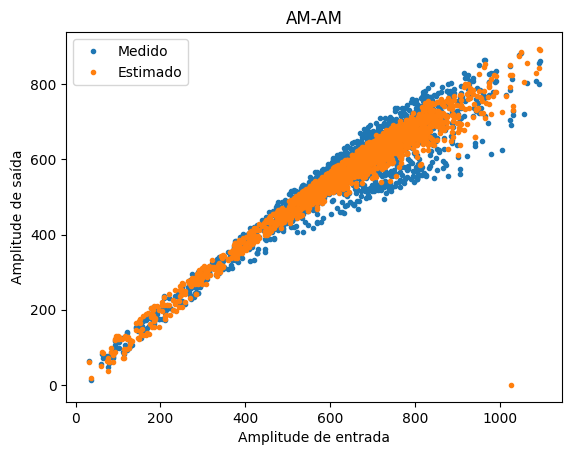

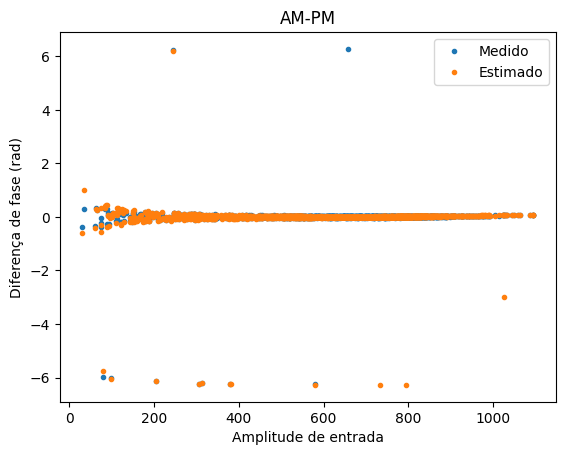

In [80]:
# Gráficos AM-AM e AM-PM
plt.figure()
plt.plot(np.abs(in_val_fixed[M:]), np.abs(out_val_fixed[M:]), '.', label='Medido')
plt.plot(np.abs(in_val_fixed[M:]), np.abs(predicted_val_fixed), '.', label='Estimado')
plt.xlabel('Amplitude de entrada')
plt.ylabel('Amplitude de saída')
plt.title('AM-AM')
plt.legend()

plt.figure()
plt.plot(np.abs(in_val_fixed[M:]), np.angle(out_val_fixed[M:])-np.angle(in_val_fixed[M:]), '.', label='Medido')
plt.plot(np.abs(in_val_fixed[M:]), np.angle(predicted_val_fixed)-np.angle(in_val_fixed[M:]), '.', label='Estimado')
plt.xlabel('Amplitude de entrada')
plt.ylabel('Diferença de fase (rad)')
plt.title('AM-PM')
plt.legend()
plt.show()